In [1]:
import math
from typing import Optional

import torch
from botorch.acquisition.acquisition import AcquisitionFunction
from botorch.acquisition.objective import PosteriorTransform
from botorch.exceptions import UnsupportedError
from botorch.models.gp_regression import FixedNoiseGP
from botorch.models.gpytorch import GPyTorchModel
from botorch.models.model import Model
from botorch.utils.constants import get_constants_like
from botorch.utils.probability import MVNXPB
from botorch.utils.probability.utils import (
    log_ndtr as log_Phi,
    log_phi,
    log_prob_normal_in,
    ndtr as Phi,
    phi,
)
from botorch.utils.safe_math import log1mexp, logmeanexp
from botorch.utils.transforms import convert_to_target_pre_hook, t_batch_mode_transform
from torch import Tensor
from torch.nn.functional import pad
from botorch.optim import optimize_acqf
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.analytic import AnalyticAcquisitionFunction
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qKnowledgeGradient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

In [2]:
class DiverseAcquisitionFunction(AnalyticAcquisitionFunction):
    def __init__(self, model, lambda_, epsilon_, best_f):
        super().__init__(model=model)
        self.register_buffer("lambda_", torch.as_tensor(lambda_))
        self.register_buffer("epsilon_", torch.as_tensor(epsilon_))
        self.register_buffer("best_f", torch.as_tensor(best_f))

    @t_batch_mode_transform(expected_q = 1)
    def forward(self, X: Tensor) -> Tensor:
        mean, sigma = self._mean_and_sigma(X)
        factor = (1 + self.epsilon_ ) if self.best_f > 0 else (1 - self.epsilon_)
        
        ei_portion = Phi((self.best_f - mean)/sigma) * (self.best_f - mean)
        dei_portion = phi((self.best_f - mean)/sigma) + self.lambda_ * Phi((factor * self.best_f - mean)/sigma)
        
        return ei_portion + dei_portion * sigma

In [3]:
import warnings
warnings.filterwarnings("ignore")
from botorch.test_functions import Branin, Griewank, SixHumpCamel, HolderTable, Hartmann, Michalewicz

def Gramacy(x):
    if len(x.shape) == 1:
        return torch.tensor(-np.abs(x[0] * np.exp(-(x[0]**2) - (x[1]**2))))
    
    lst = [] 
    for i in range(x.shape[0]):
        val = -np.abs(x[i][0] * np.exp(-(x[i][0]**2) - (x[i][1]**2)))
        lst.append(val)
    return torch.tensor(lst)

In [4]:
from scipy.stats import qmc

def scalarize_input(train_x, bounds):
    train_x_i = torch.clone(train_x)
    for dim in range(bounds.shape[1]):
        bound = bounds[:, dim]
        train_x_i[:, dim] -= bound[0]
        train_x_i[:, dim] /= ((bound[1] - bound[0]))
    return train_x_i

def revert_input(train_x_i, bounds):
    train_x = torch.clone(train_x_i)
    for dim in range(bounds.shape[1]):
        bound = bounds[:, dim]
        train_x[:, dim] *= ((bound[1] - bound[0]))
        train_x[:, dim] += bound[0]
    return train_x
    
def scalarize_output(train_obj):
    mean = train_obj.mean().item()
    std = train_obj.std().item()
    return (train_obj - mean)/std, mean, std

def revert_output(train_obj, mean, std):
    return train_obj * std + mean

def lhc_opt_loop(opt_func, bounds, num_sim):
    dim = bounds.shape[1]
    sampler = qmc.LatinHypercube(d = dim)
    obs_x = revert_input(torch.tensor(sampler.random(1 + num_sim * dim)), bounds)
    
    obs_obj = opt_func(obs_x)
    
    cum_min = np.minimum.accumulate(obs_obj.numpy())
    
    return obs_x, obs_obj, cum_min

def bayes_opt_loop(opt_func, bounds, num_start, num_sim, acqf_func, param_settings = {}):
    dim = bounds.shape[1]
    
    #actual observed 
    obs_x = revert_input(torch.rand(num_start * dim, dim), bounds)
    obs_obj = opt_func(obs_x).unsqueeze(-1)
    
    #regularized inputs to model
    model_bounds = torch.tensor([[0.0] * dim, [1.0] * dim])
    model_input = scalarize_input(obs_x, bounds)
    model_output, mean, sigma = scalarize_output(obs_obj)
    var = torch.zeros(model_output.shape) + 10**(-6)

    model = FixedNoiseGP(train_X = model_input, train_Y = model_output, train_Yvar = var)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    
    best_so_far = []
    best_so_far.append(model_output.min().item() * sigma + mean)

    for i in range(num_sim * dim):
        best_f = model_output.min()
        
        acqf = acqf_func(model = model, best_f = model_output.min(), **param_settings)
        
        new_point, _ = optimize_acqf(acqf, bounds=model_bounds, q = 1, num_restarts = 5, raw_samples = 100)
        eval_point = revert_input(new_point, bounds)
        eval_result = opt_func(eval_point).expand(1, 1)
        reg_eval_result = (eval_result - mean)/sigma

        model_input = torch.cat((model_input, new_point), 0)
        model_output = torch.cat((model_output, reg_eval_result), 0)
        var = torch.cat((var, torch.as_tensor(10**-6).expand(1,1)), 0)

        #condition observation
        
        model = model.condition_on_observations(X = new_point, Y = reg_eval_result, 
                                                noise = torch.as_tensor(5 * 10**-2).expand(1,1))

        #change parameters for output and refit model
        if i % 50 == 0:
            model_output = revert_output(model_output, mean, sigma)
            model_output, mean, sigma = scalarize_output(model_output)
            model = FixedNoiseGP(train_X = model_input, train_Y = model_output, train_Yvar = var)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_mll(mll)
        
        best_so_far.append(min(best_so_far[len(best_so_far) - 1], eval_result.item()))

    obs_x = revert_input(model_input, bounds)
    obs_obj = revert_output(model_output, mean, sigma)
    return obs_x, obs_obj, best_so_far

def evaluate(true_min, train_obj, train_x, epsilon_):
    factor = (1 + epsilon_) if true_min > 0 else (1 - epsilon_)

    torch_ind = train_obj < factor * true_min
    ind = []
    i = 0
    for val in torch_ind:
        if val:
            ind.append(i)
        i += 1

    feasible_sol, feasible_x = train_obj[ind], train_x[ind]
    max_dist = -1

    for i in range(feasible_sol.shape[0]):
        for j in range(i + 1, feasible_sol.shape[0]):
            val1, val2 = feasible_x[i], feasible_x[j]
            max_dist = max(max_dist, torch.norm(val1 - val2).item())
        
    return feasible_sol, feasible_x, max_dist


In [5]:
opt_func = [[Branin(), torch.tensor([[-5.0, 0.0], [10.0, 15.0]]), 0.5, "Branin"],
             [Griewank(), torch.tensor([[-5.0] * 2, [5.0] * 2]), 0.3, "Griewank"],
             [SixHumpCamel(), torch.tensor([[-3.0, -2.0], [3.0, 2.0]]), -1.2, "SixHumpCamel"],
            [HolderTable(), torch.tensor([[-10, -10.0], [10.0, 10.0]]), -19.0, "HolderTable"],
             [Gramacy, torch.tensor([[-2.0, -2.0], [6.0, 6.0]]), -0.4, "Gramacy"]]

DEI_param_settings = {"lambda_":0.5, "epsilon_":0.1}
EI_param_settings = {"maximize":False}
know_param_settings = {"num_fantasies":50}

acf_func = [(DiverseAcquisitionFunction, DEI_param_settings, "DEI"),
            (ExpectedImprovement, EI_param_settings, "EI"), ]

def testing_loop(num_start, num_sim, func_loop, acf_func, eps, num_trials):
    columns = ["opt_func", "acf_func", "num_sol", "curr_min", "max_dist", "trial"]
    results = pd.DataFrame(columns = columns)
    
    min_sol = {}
    all_x = {}
    
    for func_list in func_loop:
        opt_name = func_list[3]
        dim = func_list[1].shape[1]
        for acf_list in acf_func:
            _, _, acf_name = acf_list
            
            min_sol[(opt_name, acf_name)] = np.zeros((num_trials, dim * num_sim +1))
        min_sol[(opt_name, 'LHC')] = np.zeros((num_trials, dim * num_sim +1))
    
    for trial in range(num_trials):
        
        for func_list in func_loop:
            opt_func = func_list[0]
            bounds = func_list[1]
            true_min = func_list[2]
            opt_name = func_list[3]

            for acf_list in acf_func:
                acf, settings, acf_name = acf_list     

                x, y, best_so_far = bayes_opt_loop(opt_func, bounds, num_start, num_sim, acf, settings)

                sol_set, feas_x, max_dist = evaluate(true_min, y, x, eps)

                min_sol[(opt_name, acf_name)][trial] = best_so_far
                all_x[(opt_name, acf_name, trial + 1)] = [x.numpy(), feas_x.numpy()]

                results.loc[len(results)] = [opt_name, acf_name, len(sol_set), y.min().item(), max_dist, trial + 1]
            
            x, y, best_so_far = lhc_opt_loop(opt_func, bounds, num_sim)
            sol_set, feas_x, max_dist = evaluate(true_min, y, x, eps)
            min_sol[(opt_name, 'LHC')][trial] = best_so_far
            
            results.loc[len(results)] = [opt_name, "LHC", len(sol_set), y.min().item(), max_dist, trial + 1]
    return results, min_sol, all_x

results, min_sol, all_x  = testing_loop(5, 20, opt_func, acf_func, 0.2, 25)

In [6]:
def plot_min_sol(min_sol_copy, opt_func, acf_func, include_lhc = False, start_index = 0):
    
    min_sol = min_sol_copy.copy()
    if not include_lhc:
        prop = {}
        for key in min_sol:
            if key[1] != 'LHC':
                prop[key] = min_sol[key]

        min_sol = prop

    keys = list(min_sol.keys())
    
    assert len(keys) == opt_func * acf_func

    color_list = ['blue', 'red', 'green', 'yellow']
    plt.rcParams["figure.figsize"] = (10,10)
    ind = 0
    fig, ax = plt.subplots(opt_func)
    fig.tight_layout(pad = 1.0)
    
    acf_list = []
    for i in range(acf_func):
        acf_list.append(keys[i][1])
    
    
    for i in range(opt_func):
        length = min_sol[keys[ind]].shape[1]
        for j in range(acf_func):
            data = min_sol[keys[ind]][:, start_index:]
            mean = np.median(data, axis = 0)
            per_25 = np.quantile(data, q = 0.25, axis = 0)
            per_75 = np.quantile(data, q = 0.75, axis = 0)
            ax[i].plot(np.arange(start_index, length), mean, color = color_list[j], label = acf_list[j])
            ax[i].fill_between(np.arange(start_index, length), per_25, per_75, color = color_list[j], alpha=.15)
            ax[i].legend()
            ax[i].set_title(keys[ind][0])
            ind += 1
            
    plt.show()

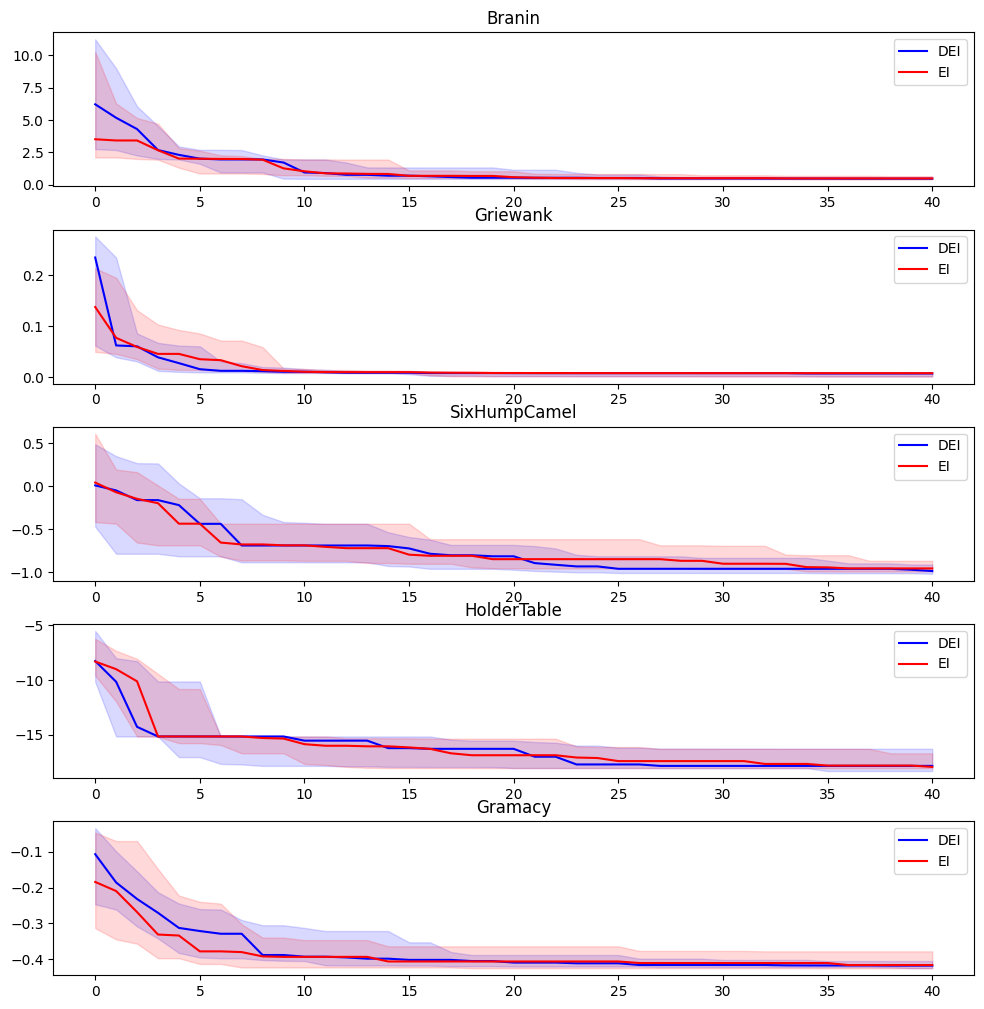

In [7]:
plot_min_sol(min_sol, 5, 2, include_lhc = False, start_index = 0)

In [8]:
def plot_points_dist(all_x_copy, num_func, num_acqf, trial):
    prog = all_x_copy.copy()
    
    all_x = {}

    for key in prog:
        if key[2] == trial:
            all_x[key] = prog[key]

    
    fig, ax = plt.subplots(num_func, num_acqf)
    fig.tight_layout(pad = 1)
    
    keys = sorted(list(all_x.keys()))
    ind = 0
    for i in range(num_func):
        for k in range(num_acqf):
            ax[i][k].scatter(all_x[keys[ind]][0][:, 0],all_x[keys[ind]][0][:, 1], label = "Solutions")
            ax[i][k].scatter(all_x[keys[ind]][1][:, 0],all_x[keys[ind]][1][:, 1], label = "Feasible", color = "red")
            ax[i][k].set_title(keys[ind][0] + " "+ keys[ind][1])
            ax[i][k].legend()
            ind += 1
    plt.show()

In [9]:
def get_dist_metric(all_x, minima, num_trials):
    
    result_map = {}
    for key in all_x:
        opt_name, acf, trial = key
        
        feasible_x = all_x[key][0]
        
        local_points = minima[opt_name]
        
        res = np.zeros(len(local_points))
        
        ind = 0
        for min_x in local_points:
            min_dist = float("inf")
            for point in feasible_x:
                min_dist = min(np.linalg.norm(point - min_x), min_dist)
            
            res[ind] = min_dist
            ind += 1
        
        if (opt_name, acf) not in result_map:
            result_map[(opt_name, acf)] = np.zeros(len(local_points))
        
        result_map[(opt_name, acf)] += res/num_trials
    
    return result_map

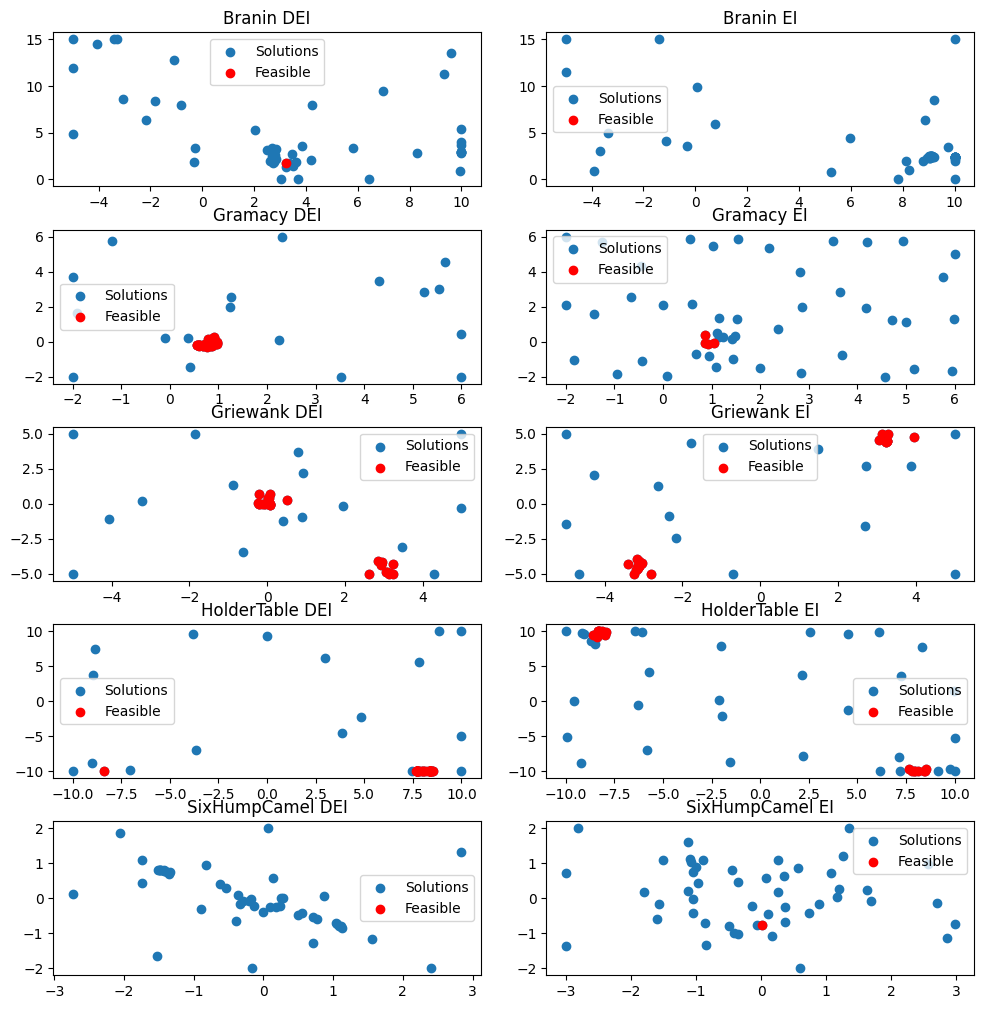

In [10]:
plot_points_dist(all_x, 5, 2, 25)

In [11]:
minima = {
    'Branin':[np.array([-3.14, 12.275]), np.array([3.14, 2.275]), np.array([9.42, 2.475])],
    'SixHumpCamel':[np.array([0.09, -0.71]), np.array([-0.09, 0.71])],
    'Griewank':[np.array([0, 0])],
    'Gramacy':[np.array([0.8, 0]), np.array([-0.8, 0])],
    'HolderTable':[np.array([8.05, 9.66]), np.array([-8.05, 9.66]), np.array([8.05, -9.66]), np.array([-8.05, -9.66])]
}

dist_metric = get_dist_metric(all_x, minima, 25)

In [12]:
def plot_dist_metric(dist_metric, num_func = 4):
    
    fig, ax = plt.subplots(num_func, 2, sharey='row')
    fig.tight_layout(pad = 1.2)
    
    ind = 0
    for key in dist_metric:
        xs = ['x' + str(k) for k in range(1, len(dist_metric[key]) + 1)]
        ax[ind // 2][ind % 2].bar(xs, dist_metric[key])
        ax[ind // 2][ind % 2].set_title(key[0] + " " + key[1])
        ind += 1
    
    plt.show()

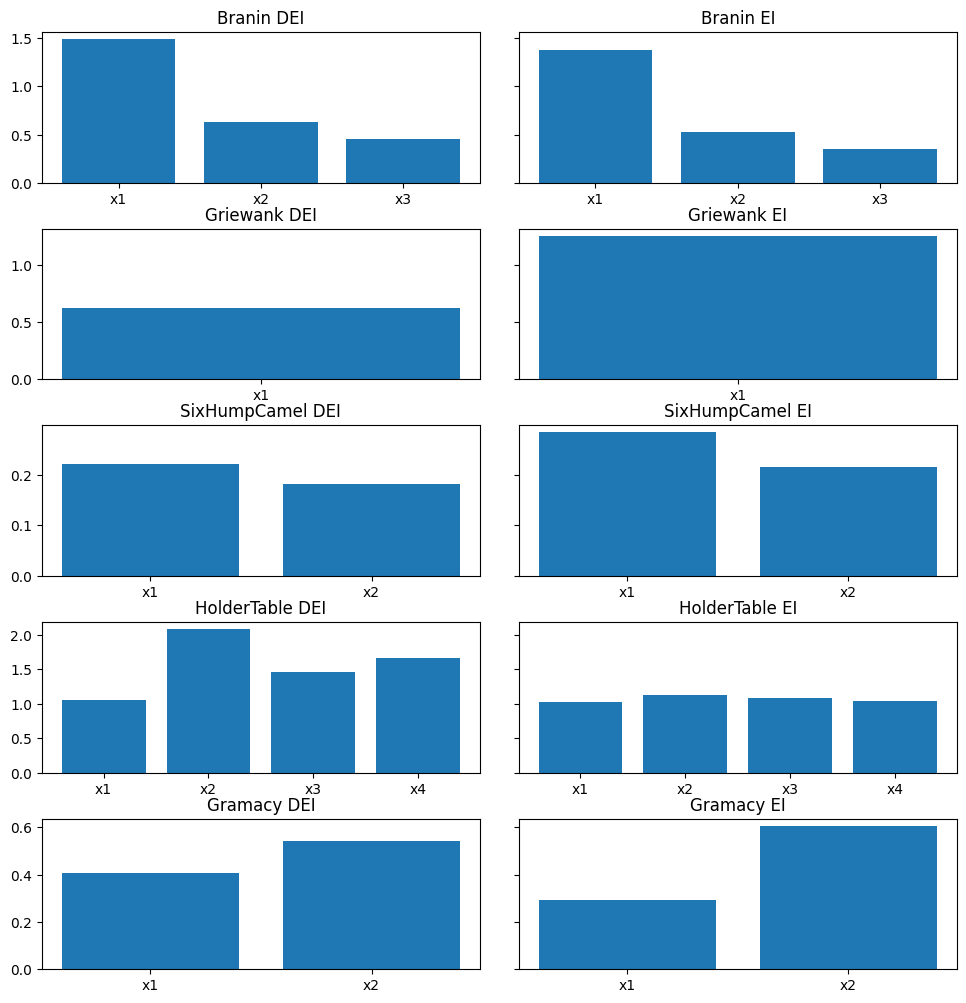

In [13]:
plot_dist_metric(dist_metric, num_func = 5)

In [14]:
high_opt_func = [[Hartmann(dim = 6), torch.tensor([[0.0] * 6, [1.0] * 6]), -3.3, "Hartmann"],
                 [Griewank(dim = 5), torch.tensor([[-5.0] * 5, [5.0] * 5]), 0.3, "Griewank"],
                 [Michalewicz(dim = 5), torch.tensor([[0.0] * 5, [3.14] * 5]), -4.4, "Michalewicz"]
                ]

h_results, h_min_sol, h_all_x  = testing_loop(5, 20, high_opt_func, acf_func, 0.2, 25)

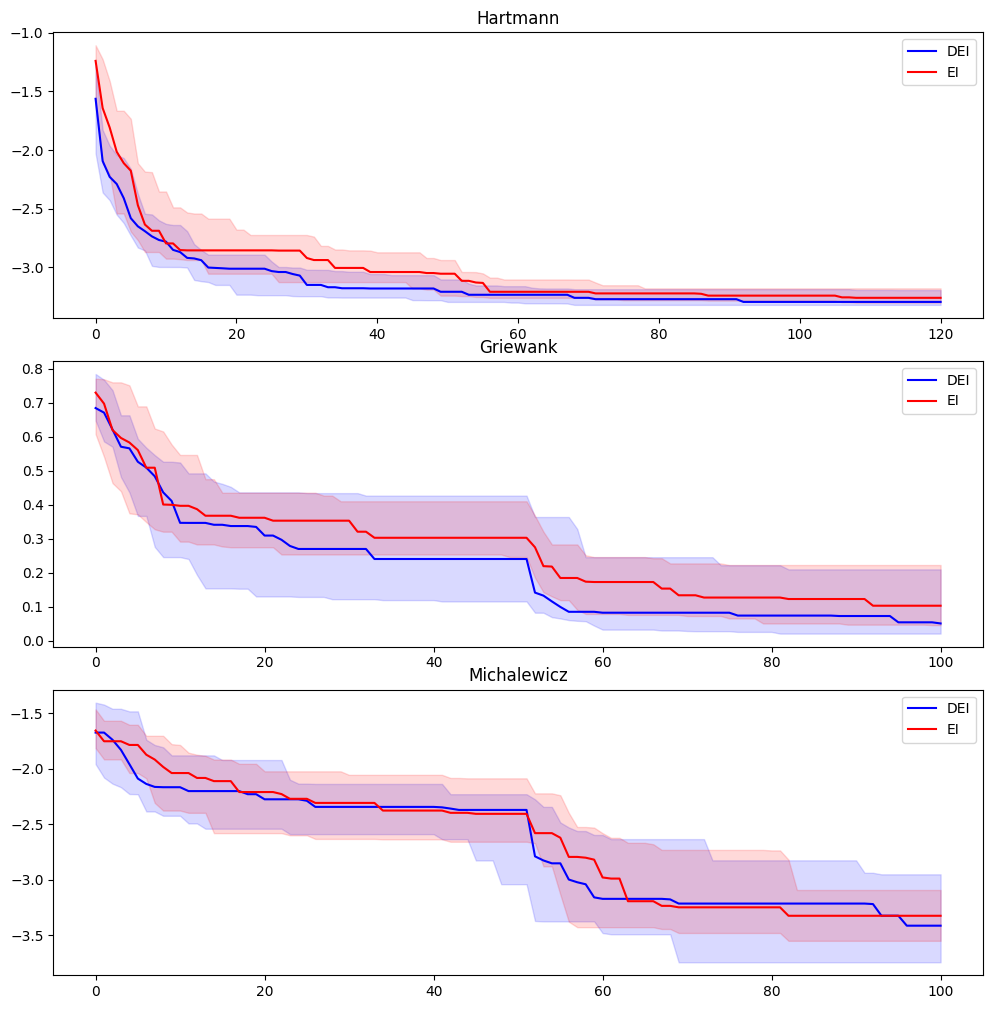

In [15]:
plot_min_sol(h_min_sol, 3, 2, include_lhc = False, start_index = 0)

In [16]:
h_results.groupby(['opt_func', 'acf_func'])['num_sol'].describe()

count   mean        std  min   25%   50%   75%   max
opt_func    acf_func                                                      
Griewank    DEI        25.0  20.96  20.191747  0.0   7.0  13.0  29.0  74.0
            EI         25.0   8.32   5.185878  0.0   4.0   8.0  12.0  20.0
            LHC        25.0   0.36   0.637704  0.0   0.0   0.0   1.0   2.0
Hartmann    DEI        25.0  29.64  14.648322  7.0  22.0  25.0  34.0  61.0
            EI         25.0  15.16  14.755451  3.0   6.0   8.0  23.0  53.0
            LHC        25.0   0.08   0.276887  0.0   0.0   0.0   0.0   1.0
Michalewicz DEI        25.0   6.36  16.041301  0.0   0.0   0.0   1.0  73.0
            EI         25.0   0.32   0.556776  0.0   0.0   0.0   1.0   2.0
            LHC        25.0   0.00   0.000000  0.0   0.0   0.0   0.0   0.0

In [17]:
h_results.groupby(['opt_func', 'acf_func'])['max_dist'].describe()

count      mean       std       min       25%       50%  \
opt_func    acf_func                                                            
Griewank    DEI        25.0  1.689366  2.221716 -1.000000  0.760994  1.620492   
            EI         25.0  3.422364  4.340537 -1.000000  0.905033  1.646877   
            LHC        25.0 -0.404109  2.444973 -1.000000 -1.000000 -1.000000   
Hartmann    DEI        25.0  0.767657  0.410042  0.237158  0.352290  0.683428   
            EI         25.0  0.726572  0.414940  0.182915  0.349147  0.615805   
            LHC        25.0 -1.000000  0.000000 -1.000000 -1.000000 -1.000000   
Michalewicz DEI        25.0 -0.727771  0.559175 -1.000000 -1.000000 -1.000000   
            EI         25.0 -0.878246  0.608771 -1.000000 -1.000000 -1.000000   
            LHC        25.0 -1.000000  0.000000 -1.000000 -1.000000 -1.000000   

                           75%        max  
opt_func    acf_func                       
Griewank    DEI       1.975101   9.777758  
            EI        2.443939  13.706502  
            LHC      -1.000000  10.997383  
Hartmann    DEI       1.214314   1.401547  
            EI        1.197037   1.332808  
            LHC      -1.000000  -1.000000  
Michalewicz DEI      -1.000000   0.619062  
            EI       -1.000000   2.043853  
            LHC      -1.000000  -1.000000

In [26]:
def grad_minimize(function, x0, step_size = 0.1, grad_lim = 0.001, max_iter = 500):
    
    dim = x0.shape[1]
    x0.requires_grad_
    
    x_current = x0
    y_current = function(x0)
    
    y_current.backward()
    ind = 0 
    
    while torch.norm(x_current.grad) >= grad_lim and ind < max_iter:
        x_new = torch.tensor(x_current - x_current.grad * step_size, requires_grad = True)
        y_new = function(x_new)
        x_current = x_new
        y_current = y_new
        y_current.backward()
        ind += 1

    return x_current, y_current

def minima_finding(function, dim, bounds, num_sol = 200):
    res_x = torch.zeros(num_sol, dim)
    res_y = torch.zeros(num_sol)
    for i in range(num_sol):
        init_point = revert_input(torch.rand(1, dim), bounds)
        init_point.requires_grad = True 
        x,y = grad_minimize(function, init_point)
        res_x[i] = x
        res_y[i] = y
    
    return res_x, res_y

def minima_finding_test(data, num_sol = 200):
    res_map = {}
    for function, bounds in data:
        res_x, res_y = minima_finding(function, bounds.shape[1],bounds, num_sol = num_sol)
        res_map[function.__class__.__name__] = (res_x, res_y)
    return res_map

In [27]:
func_list = [(Hartmann(dim = 6), torch.tensor([[0.0] * 6, [1.0] * 6])),
                 (Griewank(dim = 5), torch.tensor([[-5.0] * 5, [5.0] * 5])),
                 (Michalewicz(dim = 5), torch.tensor([[0.0] * 5, [3.14] * 5]))]

res_map = minima_finding_test(func_list, num_sol = 1000)

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def calculate_wss(points, max_k = 10):
    sse = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += np.linalg.norm(curr_center - points[i]) ** 2
        sse.append(curr_sse)
    return sse

def calculate_sil(points, max_k = 10):
    sil = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters = k).fit(points)
        labels = kmeans.labels_
        sil.append(silhouette_score(points, labels, metric = 'euclidean'))
        
    return sil

def plot_clusters(res_map, max_k = 10, get_sil = False):
    
    fig, ax = plt.subplots(len(res_map))
    
    fig.tight_layout(pad = 1)
    ind = 0
    for func in res_map:
        
        metric_func = calculate_sil if get_sil else calculate_wss
        
        metric = metric_func(res_map[func][0].detach().numpy(), max_k)
        ax[ind].plot(np.arange(2, max_k + 1), metric)
        ax[ind].set_title(func)
        
        ind += 1

def get_optimal_centers(res_map, dim_ref = {'Hartmann':6, 'Griewank':20, 'Michalewicz':11}):
    
    cluster_center = {}
    for func in dim_ref:
        kmeans = KMeans(n_clusters = dim_ref[func]).fit(res_map[func][0].detach().numpy())
        cluster_center[func] = kmeans.cluster_centers_
    
    return cluster_center

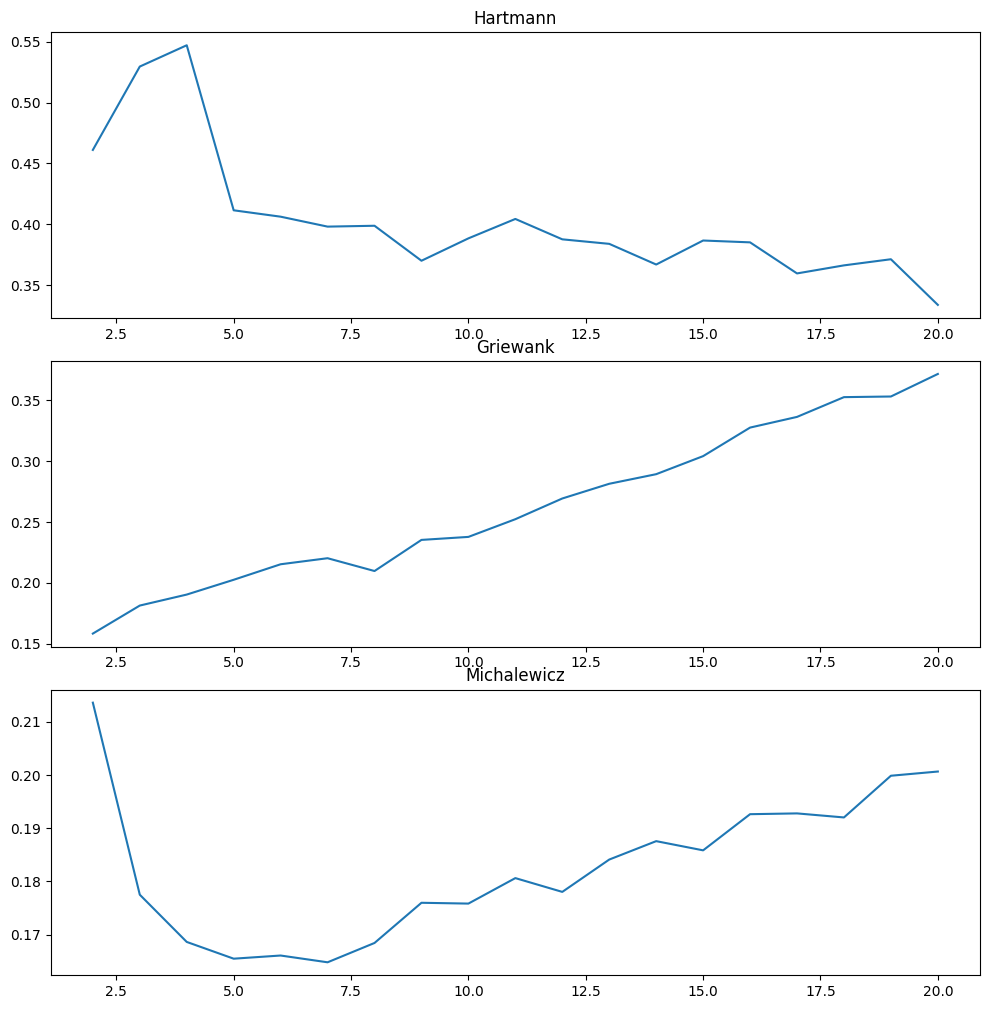

In [29]:
plot_clusters(res_map, get_sil = True, max_k = 20)

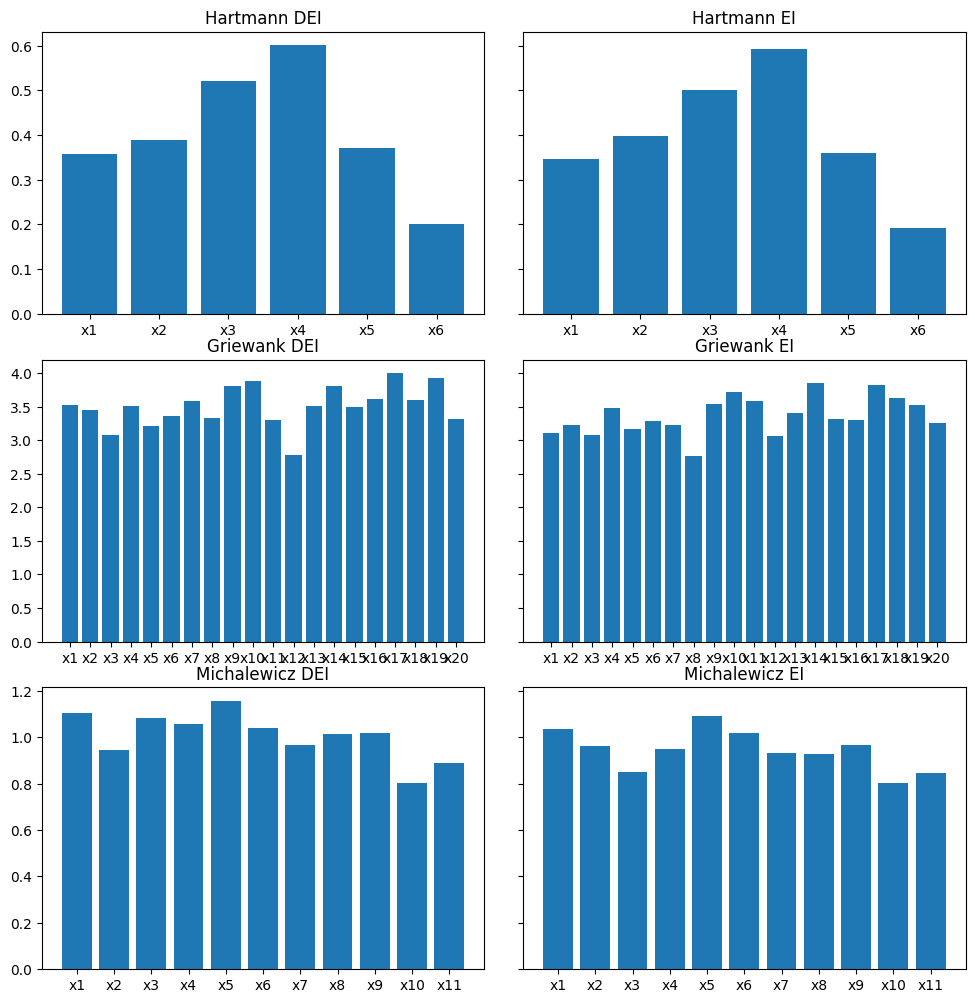

In [25]:
opt_cent = get_optimal_centers(res_map)
dist_metric_h = get_dist_metric(h_all_x, opt_cent, 25)
plot_dist_metric(dist_metric_h, num_func = 3)